In [1]:
import re
import string
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Initialize spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [2]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.keep_words = {
            "not", "no", "never", "none",
            "can", "could", "may", "might", "must", "should",
            "all", "any", "some", "few", "many",
            "now", "soon", "immediately", "recently",
            "if", "unless", "until",
            "high", "critical", "low", "medium", "zero"
        }
        
        # Update stop words
        for word in self.keep_words:
            if word in STOP_WORDS:
                STOP_WORDS.remove(word)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text):
        doc = nlp(text)
        tokens = [
            token.lemma_.lower() 
            for token in doc 
            if not token.is_stop 
            and not token.is_punct 
            and token.is_alpha
            and len(token.lemma_) > 1
        ]
        return " ".join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            return X.apply(lambda x: self.preprocess_text(self.clean_text(x)))
        elif isinstance(X, np.ndarray):
            return np.array([self.preprocess_text(self.clean_text(text)) for text in X])
        elif isinstance(X, str):
            return np.array([self.preprocess_text(self.clean_text(X))])
        else:
            raise ValueError("Input must be string, NumPy array, or Pandas Series")

In [28]:
df = pd.read_csv("expanded_data.csv", encoding='latin1')  # or 'ISO-8859-1'


In [29]:
df = df.dropna()

In [30]:
# Assuming df is your DataFrame with text in column 4 and labels in column 3
X = df.iloc[:, 0]
y = df.iloc[:, 1]

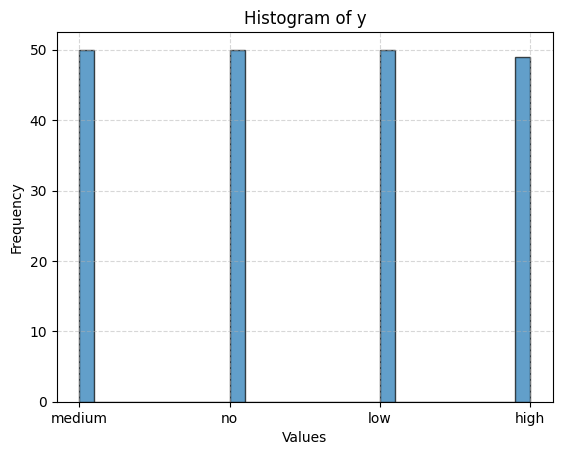

In [31]:
import matplotlib.pyplot as plt
import numpy as np  # Only needed if generating random data

# Example data (replace with your 'x')
# x = np.random.normal(0, 1, 1000)  # 1000 random numbers from a normal distribution

# Plot histogram
plt.hist(y, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of y")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [32]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
# Define the complete pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=[5,3,4,6],  # Inverse of your support counts
        objective='multi:softmax',
        num_class=4
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# Train pipeline
pipeline.fit(X_train, y_train)

c:\Users\WILSON\anaconda3\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [16:48:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_ty..._weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=4, ...))])

In [34]:
# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Side-by-side comparison
results = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred)
})
print(results)
results

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.89      1.00      0.94        25
           2       1.00      0.80      0.89        25
           3       0.92      0.96      0.94        25

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion Matrix:
 [[24  1  0  0]
 [ 0 25  0  0]
 [ 2  1 20  2]
 [ 0  1  0 24]]
    Actual Predicted
0     high      high
1      low       low
2   medium    medium
3     high      high
4   medium        no
..     ...       ...
95    high      high
96     low       low
97    high      high
98    high      high
99     low       low

[100 rows x 2 columns]


,Actual,Predicted
0,high,high
1,low,low
2,medium,medium
3,high,high
4,medium,no
...,...,...
95,high,high
96,low,low
97,high,high
98,high,high


In [35]:
# Example 1: Single text prediction
single_text = "Police foil kidnap attempt, kill one bandit in Katsina"
print("Prediction:", le.inverse_transform(pipeline.predict(single_text)))

# Example 2: NumPy array prediction
text_array = np.array([
  "Armed men amputate Plateau youth returning from burial",
  "Army condemns viral video alleging attack plan on South-East",
  "Troops kill bandit, rescue kidnap victim in Plateau forest operation"
])
print("Predictions:", le.inverse_transform(pipeline.predict(text_array)))

Prediction: ['medium']
Predictions: ['medium' 'no' 'high']


In [36]:
import joblib  # Directly import joblib

In [37]:
joblib.dump(pipeline, 'incident_classifier_pipeline.pkl')

['incident_classifier_pipeline.pkl']

In [38]:
model = joblib.load('incident_classifier_pipeline.pkl')

In [39]:
a = ("Bandits kill 19, raze houses in fresh Katsina attack")
b = "Many feared dead in fresh Benue attack - Punch Newspapers"

print("Predictions:", le.inverse_transform(pipeline.predict(a)))
print("Predictions:", le.inverse_transform(pipeline.predict(b)))




Predictions: ['high']
Predictions: ['medium']


In [15]:
! pip freeze > requirements.txt